In [1]:
from helpers import *
from plots import *

xp = gwpop.cupy_utils.xp

### Posteriors

In [2]:
posts = pd.read_pickle("bbh_spin/posterior_samples/posteriors_1.pkl") + pd.read_pickle("bbh_spin/posterior_samples/posteriors_2.pkl")
posts_zero = pd.read_pickle("bbh_spin/posterior_samples/posteriors_zero_1.pkl") + pd.read_pickle("bbh_spin/posterior_samples/posteriors_zero_2.pkl")

event_ids = []
ff = open("bbh_spin/posterior_samples/event_list.txt","r")
for line in ff.read().splitlines():
    event_ids.append(line)

### Extended Model without selection effects

In [3]:
from gwpopulation.utils import beta_dist, truncnorm

def iid_spin_magnitude_beta_truncated_gaussian(dataset, amax=1, alpha_chi=1, beta_chi=1, lambda_chi_peak=0, sigma_chi_peak=0):

    return independent_spin_magnitude_beta_truncated_gaussian(
        dataset, alpha_chi, alpha_chi, beta_chi, beta_chi, amax, amax, lambda_chi_peak, lambda_chi_peak, sigma_chi_peak, sigma_chi_peak)

def independent_spin_magnitude_beta_truncated_gaussian(
    dataset, alpha_chi_1, alpha_chi_2, beta_chi_1, beta_chi_2, amax_1, amax_2, lambda_chi_peak_1, lambda_chi_peak_2, sigma_chi_peak_1, sigma_chi_peak_2):
 
    if alpha_chi_1 < 0 or beta_chi_1 < 0 or alpha_chi_2 < 0 or beta_chi_2 < 0:
        return 0
    
    if (sigma_chi_peak_1 == 0 or sigma_chi_peak_2 == 0):
        prior = (
            (1 - lambda_chi_peak_1) * beta_dist(dataset["a_1"], alpha_chi_1, beta_chi_1, scale=amax_1)
                 + lambda_chi_peak_1 * np.nan_to_num(np.multiply((dataset["a_1"] == 0), np.inf))
        ) * (
            (1 - lambda_chi_peak_2) * beta_dist(dataset["a_2"], alpha_chi_2, beta_chi_2, scale=amax_2)
                 + lambda_chi_peak_2 * np.nan_to_num(np.multiply((dataset["a_2"] == 0), np.inf))
        )
        
    else:
        prior = (
            (1 - lambda_chi_peak_1) * beta_dist(dataset["a_1"], alpha_chi_1, beta_chi_1, scale=amax_1) 
            + lambda_chi_peak_1 * truncnorm(dataset["a_1"], mu=0, sigma=sigma_chi_peak_1, low=0, high=amax_1)
        ) * (
            (1 - lambda_chi_peak_2) * beta_dist(dataset["a_2"], alpha_chi_2, beta_chi_2, scale=amax_2) 
            + lambda_chi_peak_2 * truncnorm(dataset["a_2"], mu=0, sigma=sigma_chi_peak_2, low=0, high=amax_2)
        )

    return prior

In [4]:
"""
Likelihoods for population inference
"""

import types

import numpy as np
import pandas as pd
from scipy.stats import gamma
from tqdm import tqdm

from bilby.core.utils import logger
from bilby.core.likelihood import Likelihood
from bilby.hyper.model import Model

from gwpopulation.models import mass, redshift

from gwpopulation.cupy_utils import CUPY_LOADED, to_numpy, xp

INF = xp.nan_to_num(xp.inf)


class HyperparameterLikelihood(Likelihood):
    """
    A likelihood for inferring hyperparameter posterior distributions with
    including selection effects.
    See Eq. (34) of https://arxiv.org/abs/1809.02293 for a definition.
    """

    def __init__(
        self,
        posteriors1,
        posteriors2,
        hyper_prior1,
        hyper_prior2,
        ln_evidences=None,
        max_samples=1e100,
        selection_function=lambda args: 1,
        conversion_function=lambda args: (args, None),
        cupy=True,
    ):
        """
        Parameters
        ----------
        posteriors: list
            An list of pandas data frames of samples sets of samples.
            Each set may have a different size.
            These can contain a `prior` column containing the original prior
            values.
        hyper_prior: `bilby.hyper.model.Model`
            The population model, this can alternatively be a function.
        ln_evidences: list, optional
            Log evidences for single runs to ensure proper normalisation
            of the hyperparameter likelihood. If not provided, the original
            evidences will be set to 0. This produces a Bayes factor between
            the sampling power_prior and the hyperparameterised model.
        selection_function: func
            Function which evaluates your population selection function.
        conversion_function: func
            Function which converts a dictionary of sampled parameter to a
            dictionary of parameters of the population model.
        max_samples: int, optional
            Maximum number of samples to use from each set.
        cupy: bool
            If True and a compatible CUDA environment is available,
            cupy will be used for performance.
            Note: this requires setting up your hyper_prior properly.
        """
        if cupy and not CUPY_LOADED:
            logger.warning("Cannot import cupy, falling back to numpy.")

        #self.samples_per_posterior1 = max_samples
        #self.samples_per_posterior2 = max_samples
        self.data1, self.samples_per_posterior1 = self.resample_posteriors(posteriors1, max_samples=max_samples)
        self.data2, self.samples_per_posterior2 = self.resample_posteriors(posteriors2, max_samples=max_samples)
        logger.info(f"samples_per_posterior1 {self.samples_per_posterior1}, samples_per_posterior2 {self.samples_per_posterior2}")
 
        '''
        if isinstance(hyper_prior, types.FunctionType):
            hyper_prior = Model([hyper_prior])
        elif not (
            hasattr(hyper_prior, "parameters")
            and callable(getattr(hyper_prior, "prob"))
        ):
            raise AttributeError(
                "hyper_prior must either be a function, "
                "or a class with attribute 'parameters' and method 'prob'"
            )
        '''

        self.hyper_prior1 = hyper_prior1 #Model([hyper_prior1])
        self.hyper_prior2 = hyper_prior2 #Model([hyper_prior2]) #Model([mass.power_law_primary_mass_ratio, redshift.PowerLawRedshift])
        
        Likelihood.__init__(self, hyper_prior1.parameters)

        if "prior" in self.data1:
            self.sampling_prior1 = self.data1.pop("prior")
            self.sampling_prior2 = self.data2.pop("prior")
        else:
            logger.info("No prior values provided, defaulting to 1.")
            self.sampling_prior = 1

        if ln_evidences is not None:
            self.total_noise_evidence = np.sum(ln_evidences)
        else:
            self.total_noise_evidence = np.nan

        ln_evidences1 = self.data1.pop("ln_evidence")
        ln_evidences2 = self.data2.pop("ln_evidence")
        self.total_evidence1 = xp.asarray([val[0] for val in ln_evidences1])
        self.total_evidence2 = xp.asarray([val[0] for val in ln_evidences2])
        
        logger.info(f"log evidences = {self.total_evidence1}")
        logger.info(f"log evidences = {self.total_evidence2}")

        self.data2.pop("a_1")
        self.data2.pop("a_2")
        self.data2.pop("cos_tilt_1")
        self.data2.pop("cos_tilt_2")
        
        self.conversion_function = conversion_function
        self.selection_function = selection_function

        self.n_posteriors = len(posteriors1)

    __doc__ += __init__.__doc__

    def log_likelihood_ratio(self):
        self.parameters, added_keys = self.conversion_function(self.parameters)
        self.hyper_prior1.parameters.update(self.parameters)
        self.hyper_prior2.parameters.update(self.parameters)
        ln_l = xp.sum(self._compute_per_event_ln_bayes_factors())
        ln_l += self._get_selection_factor()
        if added_keys is not None:
            for key in added_keys:
                self.parameters.pop(key)
        if xp.isnan(ln_l):
            return float(-INF)
        else:
            return float(xp.nan_to_num(ln_l))

    def noise_log_likelihood(self):
        return self.total_noise_evidence

    def log_likelihood(self):
        return self.noise_log_likelihood() + self.log_likelihood_ratio()

    def _compute_per_event_ln_bayes_factors(self):
        term1 = xp.sum(self.hyper_prior1.prob(self.data1) / self.sampling_prior1, axis=-1)/self.samples_per_posterior1
        term2 = xp.sum(self.hyper_prior2.prob(self.data2) / self.sampling_prior2, axis=-1)/self.samples_per_posterior2 * xp.exp(self.total_evidence2 - self.total_evidence1)
        ln_l = xp.log((1. - self.parameters["lambda_chi_peak"])*term1 + self.parameters["lambda_chi_peak"]*term2)
        return ln_l

    def _get_selection_factor(self):
        return -self.n_posteriors * xp.log(self.selection_function(self.parameters))

    def generate_extra_statistics(self, sample):
        """
        Given an input sample, add extra statistics
        Adds the ln BF for each of the events in the data and the selection
        function
        Parameters
        ----------
        sample: dict
            Input sample to compute the extra things for.
        Returns
        -------
        sample: dict
            The input dict, modified in place.
        """
        self.parameters.update(sample.copy())
        self.parameters, added_keys = self.conversion_function(self.parameters)
        self.hyper_prior1.parameters.update(self.parameters)
        self.hyper_prior2.parameters.update(self.parameters)
        logger.info(self.parameters)
        #self.parameters.pop('')
        ln_ls = self._compute_per_event_ln_bayes_factors()
        for ii in range(self.n_posteriors):
            sample[f"ln_bf_{ii}"] = float(ln_ls[ii])
        sample["selection"] = float(self.selection_function(self.parameters))
        if added_keys is not None:
            for key in added_keys:
                self.parameters.pop(key)
        return sample

    def generate_rate_posterior_sample(self):
        r"""
        Generate a sample from the posterior distribution for rate assuming a
        :math:`1 / R` prior.
        The likelihood evaluated is analytically marginalized over rate.
        However the rate dependent likelihood can be trivially written.
        .. math::
            p(R) = \Gamma(n=N, \text{scale}=\mathcal{V})
        Here :math:`\Gamma` is the Gamma distribution, :math:`N` is the number
        of events being analyzed and :math:`\mathcal{V}` is the total observed 4-volume.
        Returns
        -------
        rate: float
            A sample from the posterior distribution for rate.
        """
        if hasattr(self.selection_function, "detection_efficiency") and hasattr(
            self.selection_function, "surveyed_hypervolume"
        ):
            efficiency, _ = self.selection_function.detection_efficiency(
                self.parameters
            )
            vt = efficiency * self.selection_function.surveyed_hypervolume(
                self.parameters
            )
        else:
            vt = self.selection_function(self.parameters)
        rate = gamma(a=self.n_posteriors).rvs() / vt
        return rate

    def resample_posteriors(self, posteriors, max_samples=1e300):
        """
        Convert list of pandas DataFrame object to dict of arrays.
        Parameters
        ----------
        posteriors: list
            List of pandas DataFrame objects.
        max_samples: int, opt
            Maximum number of samples to take from each posterior,
            default is length of shortest posterior chain.
        Returns
        -------
        data: dict
            Dictionary containing arrays of size (n_posteriors, max_samples)
            There is a key for each shared key in posteriors.
        """
        for posterior in posteriors:
            max_samples = min(len(posterior), max_samples)
        data = {key: [] for key in posteriors[0]}
        logger.debug(f"Downsampling to {max_samples} samples per posterior.")
        samples_per_posterior = max_samples
        for posterior in posteriors:
            temp = posterior.sample(samples_per_posterior)
            for key in data:
                data[key].append(temp[key])
        for key in data:
            data[key] = xp.array(data[key])
        return data, samples_per_posterior

    def posterior_predictive_resample(self, samples, return_weights=False):
        """
        Resample the original single event posteriors to use the PPD from each
        of the other events as the prior.
        There may be something weird going on with rate.
        Parameters
        ----------
        samples: pd.DataFrame, dict, list
            The samples to do the weighting over, typically the posterior from
            some run.
        return_weights: bool, optional
            Whether to return the per-sample weights, default = False
        Returns
        -------
        new_samples: dict
            Dictionary containing the weighted posterior samples for each of
            the events.
        weights: array-like
            Weights to apply to the samples, only if return_weights == True.
        """
        if isinstance(samples, pd.DataFrame):
            samples = [dict(samples.iloc[ii]) for ii in range(len(samples))]
        elif isinstance(samples, dict):
            samples = [samples]
        weights = xp.zeros((self.n_posteriors, self.samples_per_posterior))
        event_weights = xp.zeros(self.n_posteriors)
        for sample in tqdm(samples):
            self.parameters.update(sample.copy())
            self.parameters, added_keys = self.conversion_function(self.parameters)
            new_weights = self.hyper_prior.prob(self.data) / self.sampling_prior
            event_weights += xp.mean(new_weights, axis=-1)
            new_weights = (new_weights.T / xp.sum(new_weights, axis=-1)).T
            weights += new_weights
            if added_keys is not None:
                for key in added_keys:
                    self.parameters.pop(key)
        weights = (weights.T / xp.sum(weights, axis=-1)).T
        new_idxs = xp.empty_like(weights, dtype=int)
        for ii in range(self.n_posteriors):
            new_idxs[ii] = xp.asarray(
                np.random.choice(
                    range(self.samples_per_posterior),
                    size=self.samples_per_posterior,
                    replace=True,
                    p=to_numpy(weights[ii]),
                )
            )
        new_samples = {
            key: xp.vstack(
                [self.data[key][ii, new_idxs[ii]] for ii in range(self.n_posteriors)]
            )
            for key in self.data
        }
        event_weights = list(event_weights)
        weight_string = " ".join([f"{float(weight):.1f}" for weight in event_weights])
        logger.info(f"Resampling done, sum of weights for events are {weight_string}")
        if return_weights:
            return new_samples, weights
        else:
            return new_samples


class RateLikelihood(HyperparameterLikelihood):
    """
    A likelihood for inferring hyperparameter posterior distributions
    and estimating rates with including selection effects.
    See Eq. (34) of https://arxiv.org/abs/1809.02293 for a definition.
    """

    __doc__ += HyperparameterLikelihood.__init__.__doc__

    def _get_selection_factor(self):
        ln_l = -self.selection_function(self.parameters) * self.parameters["rate"]
        ln_l += self.n_posteriors * xp.log(self.parameters["rate"])
        return ln_l

    def generate_rate_posterior_sample(self):
        """
        Since the rate is a sampled parameter,
        this simply returns the current value of the rate parameter.
        """
        return self.parameters["rate"]

In [5]:
model1 = bilby.hyper.model.Model([mass.power_law_primary_mass_ratio,
                                  iid_spin_magnitude_beta_truncated_gaussian,
                                  spin.iid_spin_orientation_gaussian_isotropic,
                                  redshift.PowerLawRedshift()])

model2 = bilby.hyper.model.Model([mass.power_law_primary_mass_ratio, 
                                  redshift.PowerLawRedshift()])

In [6]:
def prior_conversion1(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    return parameters

def prior_conversion2(parameters):
    mu = parameters["mu_chi"]
    var = parameters["sigma_chi"]
    added_keys = pd.DataFrame()
    parameters["alpha_chi"] = (mu ** 2 * (1 - mu) - mu * var) / var
    parameters["beta_chi"] = (mu * (1 - mu) ** 2 - (1 - mu) * var) / var
    added_keys["alpha_chi"] = parameters["alpha_chi"]
    added_keys["beta_chi"] = parameters["beta_chi"]
    return parameters, added_keys

In [7]:
priors = PriorDict(conversion_function = prior_conversion1)

# mass
priors["alpha"] = Uniform(minimum = -4, maximum = 12, latex_label =r'$\alpha$')
priors["beta"] = Uniform(minimum = -4, maximum = 12, latex_label =r'$\beta_\mathrm{q}$')
priors["mmin"] = Uniform(minimum = 2, maximum = 10, latex_label =r'$m_\mathrm{min}$ $[M_\odot]$')
priors["mmax"] = Uniform(minimum = 30, maximum = 100, latex_label =r'$m_\mathrm{max}$ $[M_\odot]$')

# spin magnitude 
priors["mu_chi"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\mu_\chi$')
priors["sigma_chi"] = Uniform(minimum = 0, maximum = 0.25, latex_label = r'$\sigma^2_\chi$')
priors["lambda_chi_peak"] = Uniform(minimum = 0, maximum = 1, latex_label = r'$\lambda_\mathrm{0}$')
priors["sigma_chi_peak"] = 0
priors["amax"] = 1
priors["alpha_chi"] = Constraint(minimum = 1, maximum = 1e5)
priors["beta_chi"] = Constraint(minimum = 1, maximum = 1e5)

# spin orientation
priors["xi_spin"] = Uniform(minimum = 0, maximum = 1, latex_label=r'$\zeta$')
priors["sigma_spin"] = Uniform(minimum = 0, maximum = 4, latex_label=r'$\sigma_t$')
priors["zmin"] = Uniform(minimum=-1, maximum=1, name='zmin', latex_label='$z_{\\min}$')

# redshift
priors["lamb"] = Uniform(minimum=-10, maximum=10, name='lamb', latex_label="$\\lambda_z$")

In [8]:
likelihood = HyperparameterLikelihood(posteriors1 = posts,
                                      posteriors2 = posts_zero,
                                      hyper_prior1 = model1,
                                      hyper_prior2 = model2,
                                      conversion_function = prior_conversion2)

18:10 bilby INFO    : samples_per_posterior1 23984, samples_per_posterior2 32206
18:10 bilby INFO    : log evidences = [-1.97076791e+04 -1.96400883e+04 -1.83249796e+04 -9.11298420e+03
 -3.64276562e+04 -1.24687154e+04 -1.35702853e+04 -1.39287408e+04
 -1.39280258e+04 -9.18474989e+03 -5.86245000e+03  8.00000000e+00
 -1.19764000e+04 -2.80064000e+03 -1.86898000e+03 -1.97996000e+03
 -2.80438000e+03 -1.17156000e+04 -5.87187000e+03 -7.96574000e+03
  1.00000000e+01  1.00000000e+01 -1.19380166e+04 -1.89517000e+03
 -1.56896400e+04 -2.81296000e+03 -3.91131000e+03 -7.88885000e+03
 -2.81298000e+03 -2.82154000e+03 -1.59099600e+04 -1.59376800e+04
 -2.39370500e+04 -2.72098000e+03 -4.79665800e+04 -7.97393000e+03
 -1.17241000e+04  1.00000000e+01 -2.39979300e+04 -7.99795000e+03
 -2.83461000e+03 -9.70623700e+04 -1.19876000e+04 -1.59608800e+04]
18:10 bilby INFO    : log evidences = [-1.97063920e+04 -1.96390399e+04 -1.83394261e+04 -9.11253073e+03
 -3.64263007e+04 -1.24702719e+04 -1.35695259e+04 -1.39283146e+

In [9]:
likelihood.parameters.update(priors.sample())

In [10]:
result = bilby.run_sampler(likelihood = likelihood, priors = priors, sampler='dynesty', 
                           nlive = 1000, label='extended_spin_mass_redshift',
                           outdir = 'Results/extended_spin_mass_redshift', clean = True)

18:10 bilby INFO    : Running for label 'extended_spin_mass_redshift', output will be saved to 'Results/extended_spin_mass_redshift'
18:10 bilby INFO    : Search parameters:
18:10 bilby INFO    :   alpha = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\alpha$', unit=None, boundary=None)
18:10 bilby INFO    :   beta = Uniform(minimum=-4, maximum=12, name=None, latex_label='$\\beta_\\mathrm{q}$', unit=None, boundary=None)
18:10 bilby INFO    :   mmin = Uniform(minimum=2, maximum=10, name=None, latex_label='$m_\\mathrm{min}$ $[M_\\odot]$', unit=None, boundary=None)
18:10 bilby INFO    :   mmax = Uniform(minimum=30, maximum=100, name=None, latex_label='$m_\\mathrm{max}$ $[M_\\odot]$', unit=None, boundary=None)
18:10 bilby INFO    :   mu_chi = Uniform(minimum=0, maximum=1, name=None, latex_label='$\\mu_\\chi$', unit=None, boundary=None)
18:10 bilby INFO    :   sigma_chi = Uniform(minimum=0, maximum=0.25, name=None, latex_label='$\\sigma^2_\\chi$', unit=None, boundary=None)
18:10

0it [00:00, ?it/s]

18:11 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'rwalk', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 1000, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 600, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7fe2908c6b20>>, 'dlogz': 0.1, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
18:11 bilby INFO    : Checkpoint every check_point_delta_t = 600s
18:11 bilby INFO    : Using dynesty version 1.0.1
18:11 bilby INFO    : Using the bilby-implemented rwalk sam

04:11 bilby INFO    : Written checkpoint file Results/extended_spin_mass_redshift/extended_spin_mass_redshift_resume.pickle
04:22 bilby INFO    : Written checkpoint file Results/extended_spin_mass_redshift/extended_spin_mass_redshift_resume.pickle
04:22 bilby INFO    : Writing 122 current samples to Results/extended_spin_mass_redshift/extended_spin_mass_redshift_samples.dat
04:32 bilby INFO    : Written checkpoint file Results/extended_spin_mass_redshift/extended_spin_mass_redshift_resume.pickle
04:32 bilby INFO    : Writing 175 current samples to Results/extended_spin_mass_redshift/extended_spin_mass_redshift_samples.dat
04:43 bilby INFO    : Written checkpoint file Results/extended_spin_mass_redshift/extended_spin_mass_redshift_resume.pickle
04:43 bilby INFO    : Writing 220 current samples to Results/extended_spin_mass_redshift/extended_spin_mass_redshift_samples.dat
04:53 bilby INFO    : Written checkpoint file Results/extended_spin_mass_redshift/extended_spin_mass_redshift_resume.

07:56 bilby INFO    : Sampling time: 13:42:21.372389
07:56 bilby INFO    : Summary of results:
nsamples: 18394
ln_noise_evidence:    nan
ln_evidence:    nan +/-  0.148
ln_bayes_factor: -71.554 +/-  0.148



mu_chi sigma_chi 0.022394333301219028
mu_chi xi_spin 0.04367371952794426
mu_chi sigma_spin 0.043028725085800267
mu_chi lambda_chi_peak 0.02097632719622309
mu_chi zmin 0.03284698211522174
sigma_chi xi_spin 0.03863785162628414
sigma_chi sigma_spin 0.03806722929723356
sigma_chi lambda_chi_peak 0.01855761832590141
sigma_chi zmin 0.029059508442533733
xi_spin sigma_spin 0.07423920476537792
xi_spin lambda_chi_peak 0.0361913081747309
xi_spin zmin 0.05667223061603988
sigma_spin lambda_chi_peak 0.03565681757308462
sigma_spin zmin 0.055835267926203955
lambda_chi_peak zmin 0.027219464364175272


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.019996385962844324
mu_chi xi_spin 0.03862596159633301
mu_chi sigma_spin 0.03850251817297847
mu_chi lambda_chi_peak 0.020772445464816332
mu_chi zmin 0.03058750090079891


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi xi_spin 0.03351469428247833
sigma_chi sigma_spin 0.03340758578798579
sigma_chi lambda_chi_peak 0.018023684860673232
sigma_chi zmin 0.02653994099276037


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin sigma_spin 0.06453166727580961
xi_spin lambda_chi_peak 0.034815399169948136
xi_spin zmin 0.05126580090322929


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_spin lambda_chi_peak 0.03470413379605513
sigma_spin zmin 0.05110196223868955


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


lambda_chi_peak zmin 0.027569955787807784


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


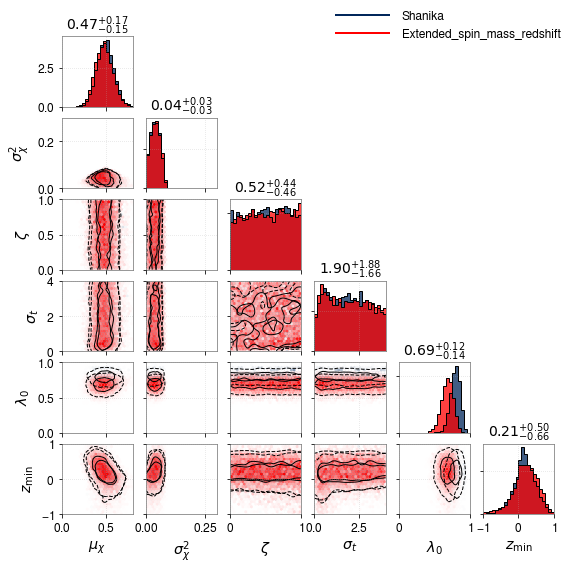

In [11]:
overlayed_plot_extended("Results/O3a_Shanika_extended_results/O3a_Shanika_extended_results.json", 
                        "Results/extended_spin_mass_redshift/extended_spin_mass_redshift_result.json", 
                        "extended_spin_mass_redshift", "Shanika", "Extended_spin_mass_redshift", save = True)

mu_chi sigma_chi 0.02060076499851247
mu_chi xi_spin 0.040215218929693125
mu_chi sigma_spin 0.04048140268875856
mu_chi lambda_chi_peak 0.018976403042088773
mu_chi zmin 0.030628288904185813
sigma_chi xi_spin 0.03542934276978397
sigma_chi sigma_spin 0.03566384890678066
sigma_chi lambda_chi_peak 0.01671808598359568
sigma_chi zmin 0.026983320616393584
xi_spin sigma_spin 0.06962020545184819
xi_spin lambda_chi_peak 0.03263575347635299
xi_spin zmin 0.0526747499967465
sigma_spin lambda_chi_peak 0.03285176889965469
sigma_spin zmin 0.05302340315182389
lambda_chi_peak zmin 0.02485569674075509


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.019996385962844324
mu_chi xi_spin 0.03862596159633301
mu_chi sigma_spin 0.03850251817297847
mu_chi lambda_chi_peak 0.020772445464816332
mu_chi zmin 0.03058750090079891


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi xi_spin 0.03351469428247833
sigma_chi sigma_spin 0.03340758578798579
sigma_chi lambda_chi_peak 0.018023684860673232
sigma_chi zmin 0.02653994099276037


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin sigma_spin 0.06453166727580961
xi_spin lambda_chi_peak 0.034815399169948136
xi_spin zmin 0.05126580090322929


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_spin lambda_chi_peak 0.03470413379605513
sigma_spin zmin 0.05110196223868955


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/Extended/plots.py:54: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


lambda_chi_peak zmin 0.027569955787807784


/home/deepnika.jain/O3a/Extended/plots.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


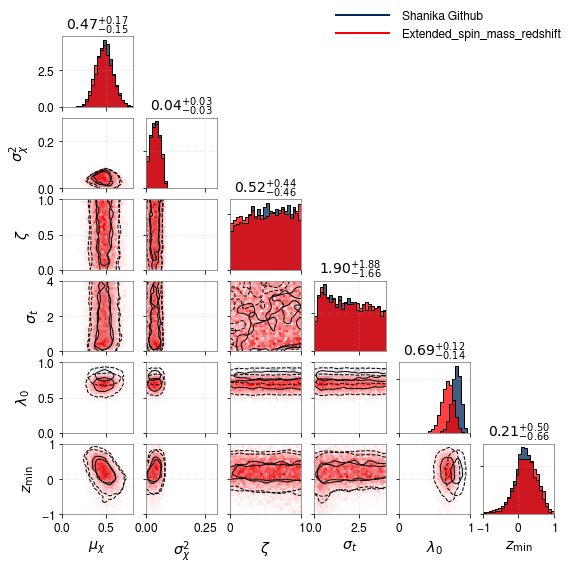

In [12]:
overlayed_plot_extended("bbh_spin/hyperposterior_samples/mass-powerlawpeak_spin-extended.json", 
                        "Results/extended_spin_mass_redshift/extended_spin_mass_redshift_result.json", 
                        "extended_spin_mass_redshift_comparison_with_github", "Shanika Github", 
                        "Extended_spin_mass_redshift", save = True)

mu_chi sigma_chi 0.022394333301219028
mu_chi xi_spin 0.04367371952794426
mu_chi sigma_spin 0.043028725085800267
mu_chi lambda_chi_peak 0.02097632719622309
mu_chi zmin 0.03284698211522174
sigma_chi xi_spin 0.03863785162628414
sigma_chi sigma_spin 0.03806722929723356
sigma_chi lambda_chi_peak 0.01855761832590141
sigma_chi zmin 0.029059508442533733
xi_spin sigma_spin 0.07423920476537792
xi_spin lambda_chi_peak 0.0361913081747309
xi_spin zmin 0.05667223061603988
sigma_spin lambda_chi_peak 0.03565681757308462
sigma_spin zmin 0.055835267926203955
lambda_chi_peak zmin 0.027219464364175272


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


mu_chi sigma_chi 0.011693995626657851
mu_chi xi_spin 0.02951763399241666
mu_chi sigma_spin 0.028544370105770857
mu_chi lambda_chi_peak 0.005489430662338898
mu_chi zmin 0.018311778890810607


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_chi xi_spin 0.027328199775253807
sigma_chi sigma_spin 0.026427126541026105
sigma_chi lambda_chi_peak 0.005082258890781752
sigma_chi zmin 0.016953525201136115


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


xi_spin sigma_spin 0.06670656237727976
xi_spin lambda_chi_peak 0.01282848588132027
xi_spin zmin 0.042793581231342595


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


sigma_spin lambda_chi_peak 0.012405501368678023
sigma_spin zmin 0.04138257900794591


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))
/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:53: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i + (j+1)*ndim))


lambda_chi_peak zmin 0.007958374882721747


/home/deepnika.jain/O3a/ExtendedDefaultModel/plots.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  ax = fig.add_subplot(ndim,ndim,int(1+(ndim+1)*i))


NameError: name 'mlines' is not defined

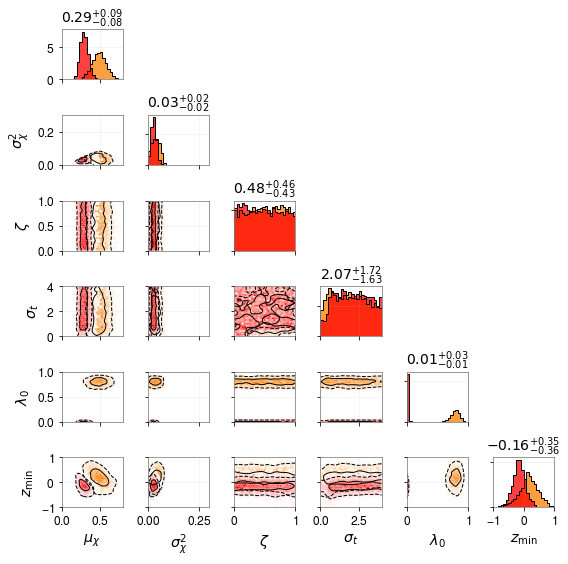

In [19]:
overlayed_plot_extended("Results/O3a_Shanika_extended_results/O3a_Shanika_extended_results.json", 
                        "Results/extended_spin_mass_redshift/extended_spin_mass_redshift_result.json", 
                        "extended_spin_mass_redshift", "Shanika", "Extended_spin_mass_redshift", save = True)